# *Detection* Model - Testing

In [1]:
!pip install adversarial-robustness-toolbox torch matplotlib numpy

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from art.attacks.evasion import ProjectedGradientDescent
from art.estimators.classification import PyTorchClassifier
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# defining model architectures

class SimpleCNN(nn.Module):
    def __init__(self, num_classes = 10): # specifically for MNIST
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim = 1)
        
        return output

In [4]:
# checking for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [5]:
# loading baseline model

baseline_model = SimpleCNN().to(device)
baseline_model.load_state_dict(torch.load("../models/baseline_model.pth", map_location = device))
baseline_model.eval()

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [6]:
# loading detection model

detection_model = SimpleCNN(num_classes = 2).to(device)
detection_model.load_state_dict(torch.load("../models/detection_model.pth", map_location = device))
detection_model.eval()

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [7]:
# preparing the test data

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
test_dataset = datasets.MNIST(root = './data', train = False, download = True, transform = transform)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = False)

In [8]:
# getting a single test sample

for image, label in test_loader:
    test_image = image.to(device)
    true_label = label.to(device)
    break

In [9]:
# generating an adversial attack

baseline_classifier_art = PyTorchClassifier(
    model = baseline_model,
    loss = nn.CrossEntropyLoss(),
    input_shape = (1, 28, 28),
    nb_classes = 10,
    device_type = "gpu" if torch.cuda.is_available() else "cpu"
)

pgd_attack = ProjectedGradientDescent(baseline_classifier_art, eps = 0.3)
x_adv_np = pgd_attack.generate(x = test_image.cpu().numpy(), y = true_label.cpu().numpy())
x_adv_tensor = torch.from_numpy(x_adv_np).to(device)

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/loki/miniconda3/envs/master-env/lib/python3.10/site-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [11]:
# running test on both models

print("Testing vulnerable baseline model...")
with torch.no_grad():
    output_adv_base = baseline_model(x_adv_tensor)
    pred_adv_base = output_adv_base.argmax(dim = 1).item()
    print(f"Adversarial image tricked baseline model into classifying as: {pred_adv_base} (True: {true_label.item()})")

print("Testing detection model...")
with torch.no_grad():
    detection_output = detection_model(test_image)
    detection_pred = detection_output.argmax(dim = 1).item()
    
    detection_result = "Adversarial" if detection_pred == 1 else "Clean"
    print(f"Detection model classified the image as: {detection_result}")
    print(f"Model's internal prediction was: {detection_pred}")

Testing vulnerable baseline model...
Adversarial image tricked baseline model into classifying as: 2 (True: 7)
Testing detection model...
Detection model classified the image as: Adversarial
Model's internal prediction was: 1


/Users/loki/miniconda3/envs/master-env/lib/python3.10/site-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


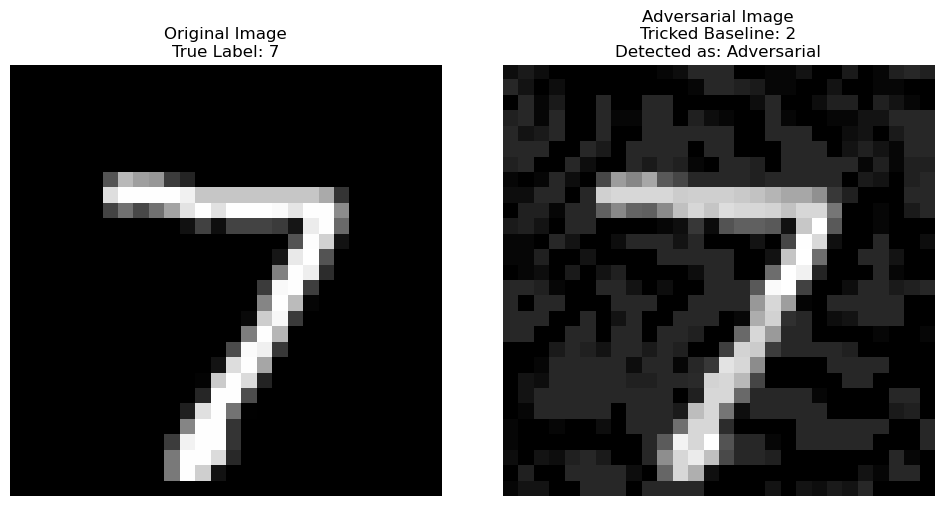

In [12]:
# visualizing the results

fig, axes = plt.subplots(1, 2, figsize = (10, 5))

# clean image
axes[0].imshow(test_image.cpu().squeeze().numpy(), cmap = "gray")
axes[0].set_title(f"Original Image\nTrue Label: {true_label.item()}")
axes[0].axis("off")

# adversarial image
axes[1].imshow(x_adv_tensor.cpu().squeeze().numpy(), cmap = "gray")
axes[1].set_title(f"Adversarial Image\nTricked Baseline: {pred_adv_base}\nDetected as: {detection_result}")
axes[1].axis("off")

plt.tight_layout()
plt.show()
